# 仅用batch1训练，在batch1-10上测试性能

In [5]:
import sys
import os

# 1. 自动定位项目根目录 (TinyML_Gas_Drift)
# 假设 Notebook 在 notebooks/ 文件夹下，'..' 就是根目录
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 2. 强制定位你的 conda 环境 site-packages (解决 DLL 报错)
# 请确保这个路径指向你安装了 CPU 版 torch 的环境
conda_env_path = r'C:\Users\yzhou\AppData\Local\anaconda3\envs\tinyml_drift\Lib\site-packages'
if conda_env_path not in sys.path:
    sys.path.insert(0, conda_env_path)

# 3. 解决 Windows 下的 DLL 冲突 (针对 WinError 1114)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
env_dll_path = r'C:\Users\yzhou\AppData\Local\anaconda3\envs\tinyml_drift\Library\bin'
if os.path.exists(env_dll_path):
    os.add_dll_directory(env_dll_path)

# 4. 现在尝试导入
try:
    import torch
    from src.data_loader import GasSensorLoader
    from src.models import GasSensorMLP
    print("✅ 环境校准成功！PyTorch 和项目模块均已加载。")
    print(f"当前 Python 解释器: {sys.executable}")
except Exception as e:
    print(f"❌ 依然存在问题: {e}")

✅ 环境校准成功！PyTorch 和项目模块均已加载。
当前 Python 解释器: C:\Users\yzhou\AppData\Local\anaconda3\envs\tinyml_drift\python.exe


正在 Batch 1 上训练 Baseline 模型...

开始评估全生命周期准确率...
Batch  1 | 准确率:  99.78%
Batch  2 | 准确率:  88.26%
Batch  3 | 准确率:  78.44%
Batch  4 | 准确率:  59.01%
Batch  5 | 准确率:  45.69%
Batch  6 | 准确率:  45.48%
Batch  7 | 准确率:  42.73%
Batch  8 | 准确率:  23.13%
Batch  9 | 准确率:  34.26%
Batch 10 | 准确率:  43.22%


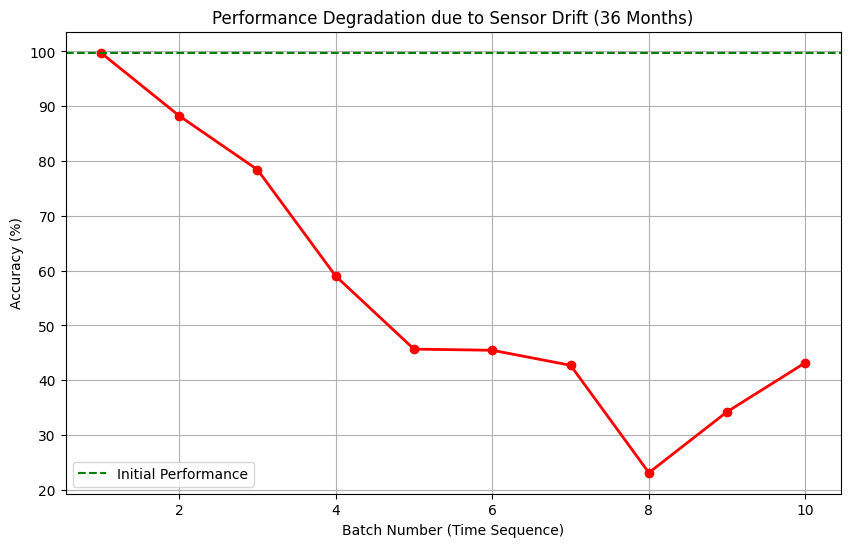

In [9]:
import torch
import torch.nn as nn          # 修复 'nn' is not defined
import torch.optim as optim    # 同时预防下一个可能的 'optim' 报错
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from src.data_loader import GasSensorLoader
from src.models import GasSensorMLP
import matplotlib.pyplot as plt
import numpy as np

# 1. 准备数据 (仅用 Batch 1)
loader = GasSensorLoader(data_dir='../Dataset')
X1, y1 = loader.load_batch(1)

# 标准化 (非常关键，记录下 scaler 以备后用)
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# 转为 PyTorch 张量
X_train = torch.FloatTensor(X1_scaled)
y_train = torch.LongTensor(y1)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. 训练模型
model = GasSensorMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("正在 Batch 1 上训练 Baseline 模型...")
for epoch in range(50):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# 3. 跨批次评估性能 (Batch 1 到 10)
accuracies = []
print("\n开始评估全生命周期准确率...")

for i in range(1, 11):
    Xi, yi = loader.load_batch(i)
    # 使用 Batch 1 的 scaler 进行转换 (模拟模型出厂后的状态)
    Xi_scaled = scaler.transform(Xi)
    
    X_test = torch.FloatTensor(Xi_scaled)
    y_test = torch.LongTensor(yi)
    
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        acc = 100 * correct / len(y_test)
        accuracies.append(acc)
        print(f"Batch {i:2d} | 准确率: {acc:6.2f}%")

# 4. 绘制性能退化曲线 (核心交付物)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracies, marker='o', linestyle='-', color='r', linewidth=2)
plt.axhline(y=accuracies[0], color='g', linestyle='--', label='Initial Performance')
plt.title("Performance Degradation due to Sensor Drift (36 Months)")
plt.xlabel("Batch Number (Time Sequence)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()